Background

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2018, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

This final project explores the best locations for Japanese restaurants throughout the city of New York. As New York is the most diverse city in the world (800 languages are spoken in New York), it has a long tradition of different ethnical restaurants. Now when the idea of a healthy lifestyle conquered the minds of people all over the country, Japanese restaurants became extremely popular, as they offer a healthy alternative to regular American eating habits. That's why Potentially the owner of the new East European restaurant can have great success and consistent profit. However, as with any business, opening a new restaurant requires serious considerations and is more complicated than it seems from the first glance. In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. So our project will attempt to answer the questions “Where should the investor open a Japanese Restaurant?” and “Where should I go If I want great Japanese food?”

Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

Method

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Japanese restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

Problem

What is / are the best location(s) for Japanese cuisine in New York City?
In what Neighborhood and/or borough should the investor open a Japanese restaurant to have the best chance of being successful?
Where would I go in New York City to have the best Japanese food?

In [1]:
#Import libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-OpenCE

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    python_abi-3.7             |          2_cp37m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    widgetsnbextension-3.5.1   |   py37h89c1867_4         1.8 MB  conda-f

In [2]:
#Define functions

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [3]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
ny_data.shape

(306, 4)

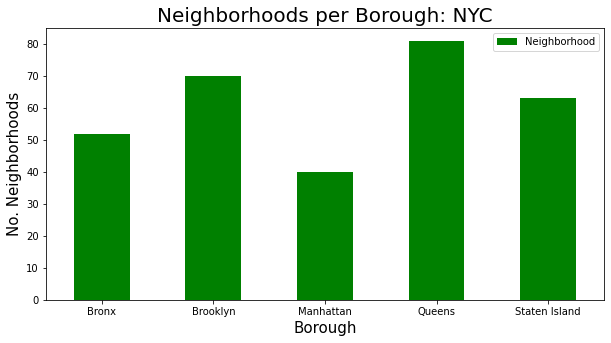

In [5]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [7]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1

for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

NameError: name 'CLIENT_ID' is not defined

In [8]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [9]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name


In [10]:
japanese_rest_ny.shape

(0, 4)

IndexError: index 0 is out of bounds for axis 0 with size 0

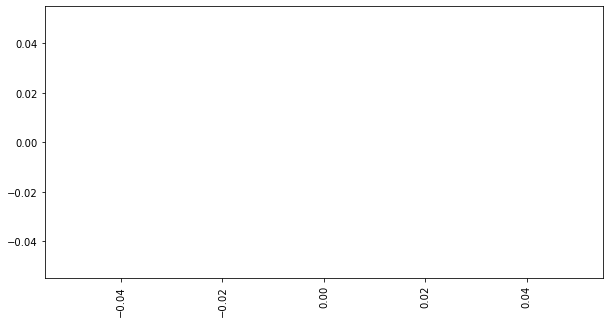

In [11]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

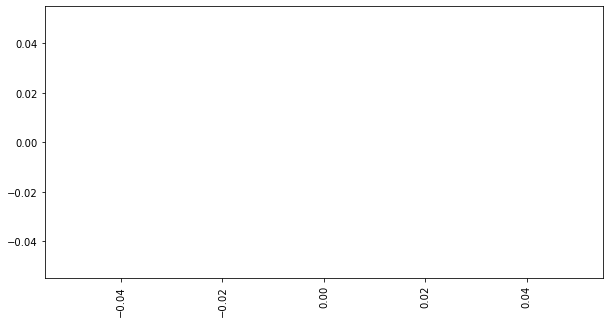

In [12]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [13]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name


In [14]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [16]:
# As I move through this project I continue to save data to a .csv file
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') 

In [17]:
japanese_rest_stats_ny.shape

(0, 7)

In [18]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       0 non-null      object
 1   Neighborhood  0 non-null      object
 2   ID            0 non-null      object
 3   Name          0 non-null      object
 4   Likes         0 non-null      object
 5   Rating        0 non-null      object
 6   Tips          0 non-null      object
dtypes: object(7)
memory usage: 0.0+ bytes


In [19]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       0 non-null      object 
 1   Neighborhood  0 non-null      object 
 2   ID            0 non-null      object 
 3   Name          0 non-null      object 
 4   Likes         0 non-null      float64
 5   Rating        0 non-null      object 
 6   Tips          0 non-null      float64
dtypes: float64(2), object(5)
memory usage: 0.0+ bytes


In [20]:
japanese_rest_stats_ny.describe()

,Likes,Tips
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [21]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

ValueError: attempt to get argmax of an empty sequence

In [22]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [23]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

ValueError: attempt to get argmax of an empty sequence

In [24]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

KeyError: "['Rating'] not in index"

In [25]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

KeyError: "['Rating'] not in index"

KeyError: 'Rating'

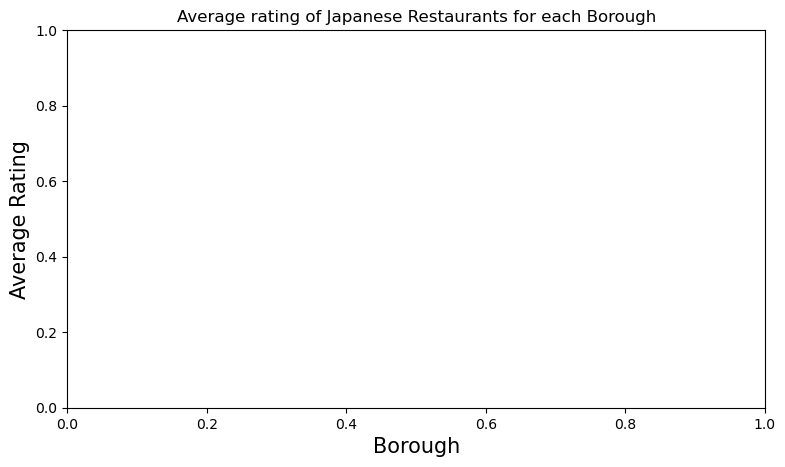

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [27]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

NameError: name 'ny_neighborhood_stats' is not defined

In [28]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

NameError: name 'ny_neighborhood_stats' is not defined